#### For Colab

In [15]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [18]:
!pip install transformers==4.1.1
!pip install -U gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


### **Config**

In [19]:
import sys
sys.path.insert(0, drive_dir)
import config

In [20]:
# General configurations

MODEL='bart'

RE_SPLITTER = '\n'              # do we split sentences of paragraphs? ('\.(?!\d)|\n')

TOKEN_MAX_LEN = 99              # max length of a word
PARA_MIN_LENGTH = 2             # minimum length for a sentence or
                                # a paragraph, in tokens

# Output path
OUTPUT_PATH = drive_dir+'experiments/exploration_output/'

Books without bullet points

9781910797938

9781912776108 -> has my questions

9781912776382 -> has my questions sometimes, sometimes nothing

9781912776665 -> has some exercises

9783318065435 -> has fast tests as well

### **Init**

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
import gensim

if 'pegasus' in MODEL:
    from transformers import PegasusTokenizer
    tokenizer =\
        PegasusTokenizer.from_pretrained('google/pegasus-large')
elif 'bart' in MODEL:
    from transformers import BartTokenizer
    tokenizer =\
        BartTokenizer.from_pretrained('facebook/bart-large-cnn')

### **Karger Books Base Dataset**

In [22]:
base_dataset = drive_dir+'datasets/karger_books_base/df.csv'
df = pd.read_csv(base_dataset)
df = df.set_index(['book', 'chapter', 'section', 'subsection'])
df.bullets = df.bullets.map(eval, na_action='ignore')

In [23]:
print('Number of books we keep: %d'%len(set(df.index.get_level_values(0))))
print('Number of chapters: %d'%len(set(zip(df.index.get_level_values(0), df.index.get_level_values(1)))))

Number of books we keep: 53
Number of chapters: 496


## **Study of the data**

### **Preprocessing**

#### Preprocessing

* Split based on RE_SPLITTER
* Explode the dataset
* Remove unwanted chars at beginning or end of sentence
* Remove multiple spaces
* Remove long words (> TOKEN_MAX_LEN chars)
* Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)

In [24]:
# Split in sentences / paragraphs based on RE_SPLITTER
df.text =\
    df.text.map(lambda x: [p.strip() for p in re.split(RE_SPLITTER, x) if p!=''],
                na_action='ignore')
    
# explode to get one row for each paragraph /sentence
df = df.explode('text')
df = df.rename(columns={'text': 'para'})
df = df.dropna()

# Remove unwanted chars at beginning or end of sentence
df.para = df.para.map(lambda p: p.lstrip('.,;:-)] \n'))
df.para = df.para.map(lambda p: p.rstrip('.,;:-([ \n'))

# Remove multiple spaces
df.para = df.para.map(lambda p:
    re.sub('\s+', ' ', p).strip())

# Remove long words (> TOKEN_MAX_LEN chars)
def para2words(para):
    return gensim.utils.simple_preprocess(
        para, deacc=True, max_len=TOKEN_MAX_LEN)
df['para_proc'] = df.para.map(para2words)

# Remove short sentences / paragraphs (< PARA_MIN_LENGTH tokens)
df.loc[df.para_proc.map(len) <\
    PARA_MIN_LENGTH, 'para_proc'] = np.nan

df = df.dropna()

### **Bullets distribution**

In [25]:
bullets_list = df.explode('bullets')['bullets'].unique()
bullets_list_ntok = [len(tokenizer.tokenize(b)) for b in bullets_list]
print('Number of bullet points:', len(bullets_list))

Number of bullet points: 2556


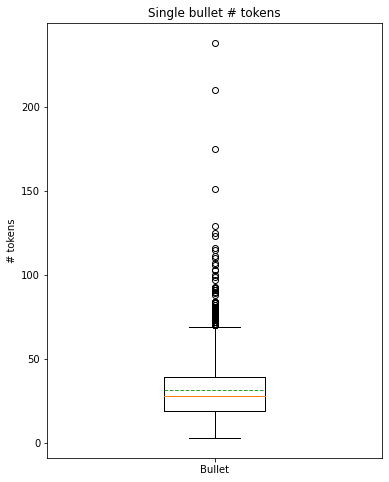

In [26]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    bullets_list_ntok,
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('Single bullet # tokens')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Bullet'])
plt.savefig(OUTPUT_PATH+'single_bullet_numtokens.png')
plt.show()

In [27]:
print('Number of tokens per one bullet, median:', np.median(bullets_list_ntok))

Number of tokens per one bullet, median: 28.0


In [28]:
df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

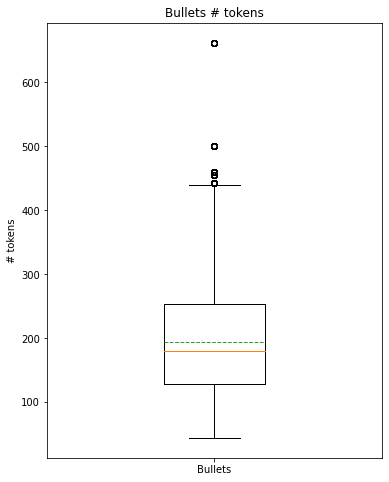

In [29]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.bullets_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)

ax.set_title('Bullets # tokens')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Bullets'])
plt.savefig(OUTPUT_PATH+'bullets_numtokens.png')
plt.show()

In [30]:
print('Number of tokens per bullet points, median:', np.median(df.bullets_num_tokens.tolist()))

Number of tokens per bullet points, median: 180.0


Let's study the outliers

In [31]:
df_explore_outliers = df[['bullets', 'bullets_num_tokens']].copy()
df_explore_outliers.bullets = df_explore_outliers.bullets.map(lambda b: ' '.join(b))
df_explore_outliers = df_explore_outliers.drop_duplicates()
df_explore_outliers = df_explore_outliers[df_explore_outliers['bullets_num_tokens'] > 400]
for idx, b in df_explore_outliers.sort_values('bullets_num_tokens', ascending=False).bullets.iteritems():
    print(idx)
    print(b)
    print()

(9781908541727, 'ch10', 'ch10', 'ch10')
Refer urgently, to be seen the same day, if your patient is:- a neonate with red eyes and eye watering or discharge (possible ophthalmia neonatorum)- a neonate or child with an abnormal red reflex (possible retinoblastoma or congenital cataract)- an infant or child with photophobia, constant tearing (epiphora), corneal enlargement or cloudy cornea (possible congenital glaucoma)- a child with red eye with pain, photophobia or blurred vision (possible corneal ulcer, iritis or endophthalmitis)- an older child with double vision (causes include brain tumor or aneurysm)- a child of any age with swollen optic disc/s on ophthalmoscopy (possible brain tumor or hydrocephalus).- an infant or child with preseptal or orbital cellulitis- an infant or child with ptosis- an infant or child with a history of eye trauma or possible shaken baby syndrome. Refer within 1 week, any child with:- squint ('turned eye', strabismus) or nystagmus (constantly moving eyes) n

### **Paragraphs distribution**

In [32]:
print('Number of paragraphs:', len(df))

Number of paragraphs: 18822


In [33]:
df['para_tokenized'] = df.para.map(tokenizer.tokenize)
df['para_num_tokens'] = df.para_tokenized.str.len()

df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

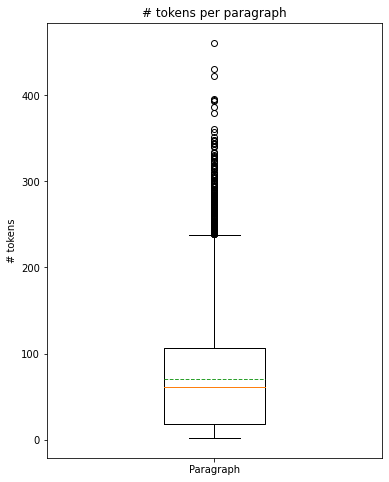

In [34]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.para_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('# tokens per paragraph')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Paragraph'])
plt.savefig(OUTPUT_PATH+'para_numtokens.png')
plt.show()

Let's study the outliers

In [35]:
df_explore_outliers = df[['para', 'para_num_tokens']].copy()
df_explore_outliers = df_explore_outliers[df_explore_outliers['para_num_tokens'] > 350]
for idx, p in df_explore_outliers.sort_values('para_num_tokens', ascending=False).para.iteritems():
    print(idx)
    print(p)
    print()

(9781910797693, 'chp4', 'sect13', 'sect13')
Epoetin. In Thailand, more than a dozen different copies of epoetin-alfa were marketed but had not been approved through stringent regulatory procedures such as in the EU and USA. Simple analytics such as isoelectric gel chromatography showed that many of these copies were structurally different from the reference drug (epoetin-alfa Epogen ®). Twelve such intended copy biologics were analyzed in a joint Thai-Dutch study. Some showed high aggregate levels and contained substantial levels of protein fragments - a critical attribute of these medicines that has been strongly associated with a rare but potentially fatal adverse drug reaction., Epoetin aggregates can promote the development of anti-drug immune reactions which can neutralize both the medicine and the erythropoietin produced by the kidneys, causing pure red cell aplasia (PRCA). Affected patients become profoundly anemic and transfusion dependent, and will die if the auto-immunity can

### **Sections distribution**

In [36]:
df = df.groupby(level=[0,1,2,3], sort=False).agg(
    {'para': lambda t: ''.join([p+'. ' for p in t]).strip(),
     'bullets': lambda b: list(b)[0]})
df = df.rename(columns={'para': 'text'})

In [37]:
print('Number of sections:', len(df))

Number of sections: 2730


In [38]:
df['text_tokenized'] = df.text.map(tokenizer.tokenize)
df['text_num_tokens'] = df.text_tokenized.str.len()

df['bullets_tokenized'] = df.bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

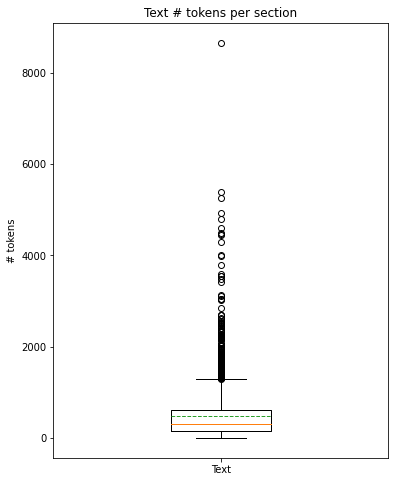

In [39]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.text_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('Text # tokens per section')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Text'])
plt.savefig(OUTPUT_PATH+'sec_text_numtokens.png')
plt.show()

Most of the sections have a low number of tokens, with a median of around 250. However, there is a consistent number of outliers with more than 1'000 tokens or less than 50.

This is a problem because the first cannot fit entirely into the model and the latter cannot be used alone to produce a summary.

In [40]:
df[['text_num_tokens', 'bullets_num_tokens']].sort_values(by='text_num_tokens', ascending=False)

,,,,text_num_tokens,bullets_num_tokens
book,chapter,section,subsection,,
9781908541277,ch_8,sec1,sec1,8660,76
9781908541178,ch_6,3.iii,3.iii,5385,211
9781908541406,ch_15,sec1,sec1,5251,222
9781908541680,ch_9,sec1,sec1,4931,143
9781910797471,ch03,sect10,sect10,4796,204
...,...,...,...,...,...
9781908541277,ch_11,ch_11,ch_11,3,378
9781912776238,ch4,ch4,ch4,3,81
9781908541680,ch_5,ch_5,ch_5,3,134


Is the number of sections in a chapter correlated with the # tokens per section in that chapter?

In [41]:
df_corr = df.groupby(level=[0, 1]).agg(
    {'text': lambda t: len(list(t)),
     'text_num_tokens': lambda tnm: np.median(list(tnm))})
df_corr = df_corr.rename(columns={'text': 'num_sections'})

In [42]:
df_corr.corr('pearson')

,num_sections,text_num_tokens
num_sections,1.00000,-0.27524
text_num_tokens,-0.27524,1.00000


The answer is yes, we have a negative correlation between the number of sections in a chapter and the number of tokens per section. This means the more sections we have in a chapter, the shorter these sections will be and viceversa.

### **Text vs Bullets length**

In [43]:
df = df.groupby(level=[0, 1]).agg(
    {'text': lambda t: ' '.join(list(t)),
     'bullets': lambda b: list(b)[0]})

In [44]:
df['text_tokenized'] = df.text.map(tokenizer.tokenize)
df['text_num_tokens'] = df.text_tokenized.str.len()

df['bullets_tokenized'] = df.dropna().bullets.map(lambda x: [tokenizer.tokenize(b) for b in x])
df['bullets_num_tokens'] = df.dropna().bullets_tokenized.map(lambda x: np.sum([len(b) for b in x]))

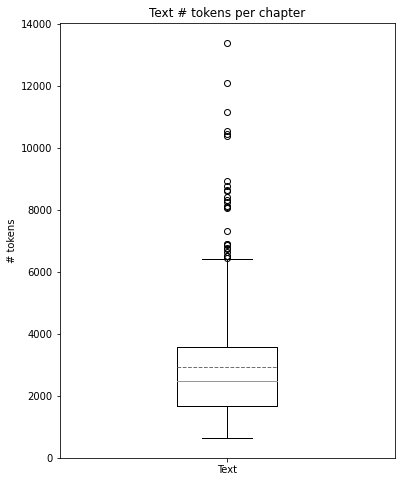

In [45]:
fig, ax = plt.subplots(figsize=(6, 8))

plt.boxplot(
    df.text_num_tokens.tolist(),
    widths=0.3,
    patch_artist=False,
    meanline=True,
    showmeans=True)
ax.grid(False)
ax.set_title('Text # tokens per chapter')
ax.set_ylabel('# tokens')
ax.set_xticklabels(['Text'])
plt.savefig(OUTPUT_PATH+'chp_text_numtokens.png')
plt.show()

Taking chapters into consideration, we can see that the number of tokens per chapter is around 3000 on average. The distribution is a bit skewed.

Since we aim to a summary of around 180 tokens, we want to keep only around **6% of the original text**.

In [46]:
df[['text_num_tokens', 'bullets_num_tokens']].sort_values(
    by='bullets_num_tokens', ascending=False)

,,text_num_tokens,bullets_num_tokens
book,chapter,,
9781908541727,ch10,1649,662
9781910797617,chp3,6631,500
9783318068207,hh-7,6452,460
9781908541727,ch11,2639,455
9781910797495,chp7,2815,443
...,...,...,...
9781910797426,ch02,1913,49
9781910797105,ch01,1006,46
9781912776153,chp6,3995,46


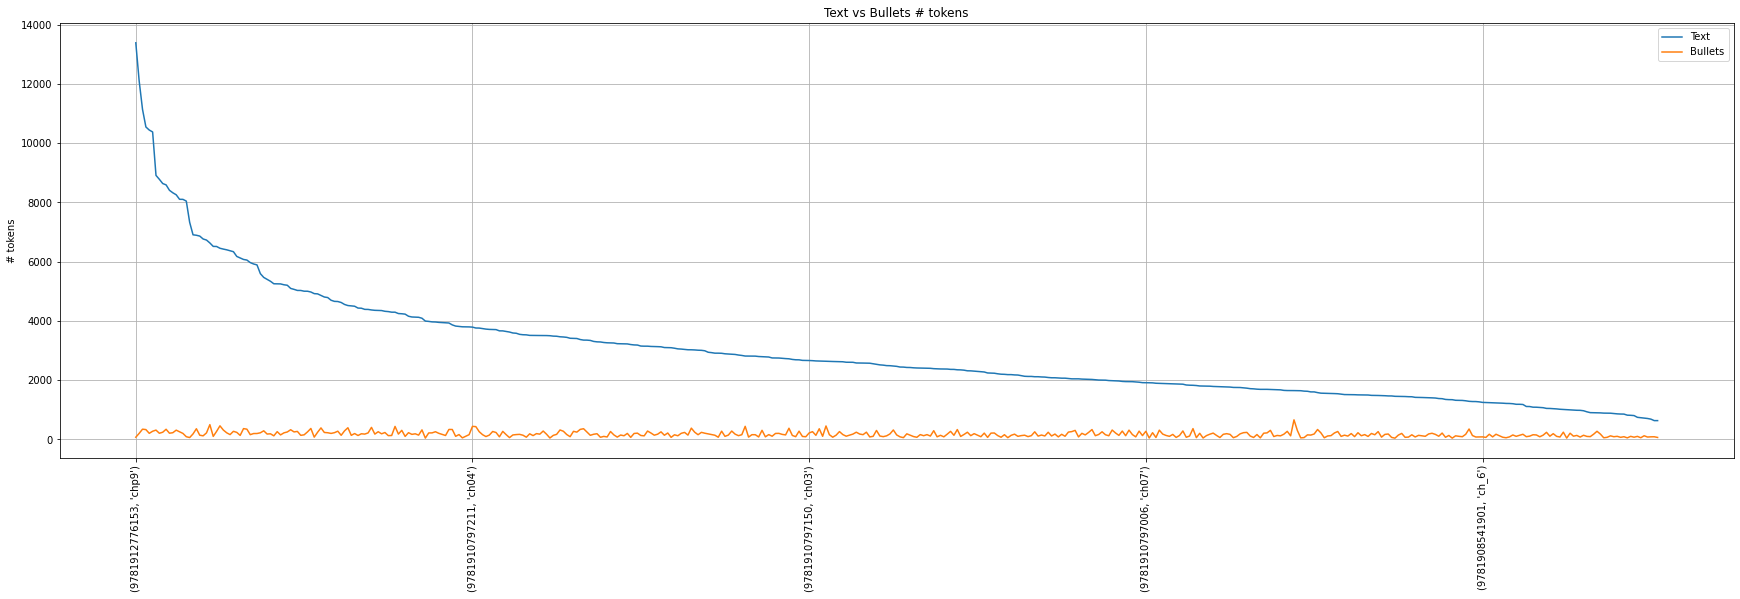

In [47]:
df_comp = df[['text_num_tokens', 'bullets_num_tokens']]\
    .sort_values(by='text_num_tokens', ascending=False)

fig, ax = plt.subplots(figsize=(30, 8))

rects1 = ax.plot(
    df_comp.text_num_tokens.tolist(),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
ax.grid()
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'chapter_vs_bullets_numtokens.png')
plt.show()

There is **not** a correlation between length of the chapter and length of the bullet points. Thus, we decide to set a fixed size for the summary (e.g. 180). Another approach would be to say we want to keep 6% of the starting text. Let's explore the two approaches in more details.

### **Variable vs fixed sized summary**

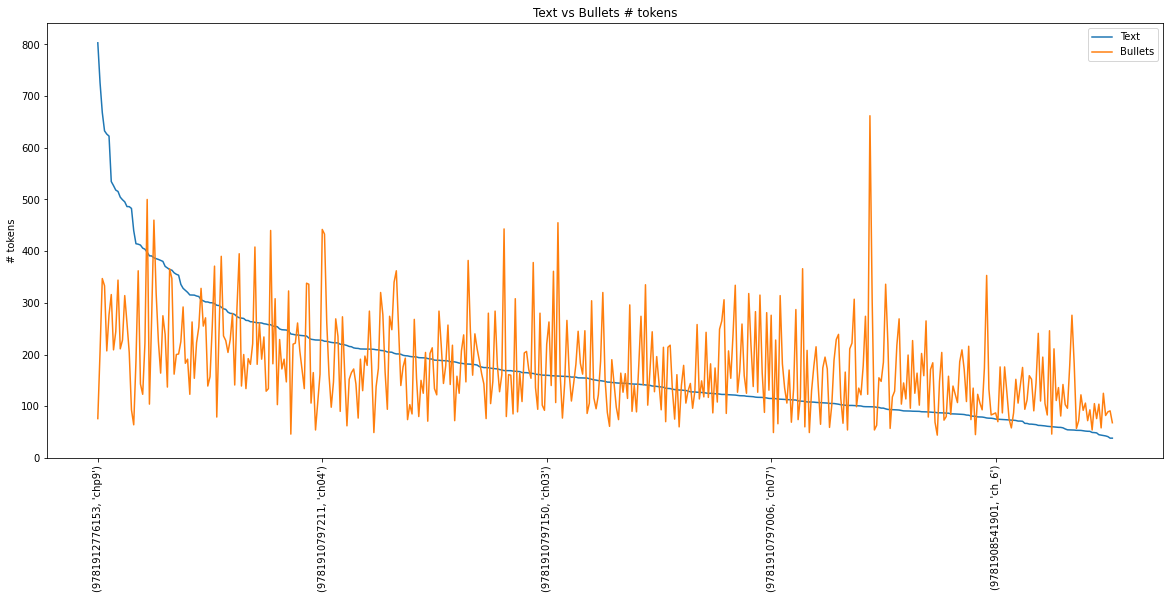

In [48]:
fig, ax = plt.subplots(figsize=(20, 8))

rects1 = ax.plot(
    (df_comp.text_num_tokens*0.06).tolist(),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'06text_summary_vs_bullets.png')
plt.show()

In [49]:
print('Mean Absolute Error:\n')
np.sum(np.abs((df_comp.text_num_tokens*0.06)-df_comp.bullets_num_tokens)) / len(df_comp)

Mean Absolute Error:



84.24710816777042

Deciding the length of the chapter summary based on the length of the summary (e.g. 6% of the text number of tokens) results in very big discrepancies between the reference summary and the generated one.

This can be seen in the plot above, where for book 1 chapter 5 and book 2 chapter 6 we have a huge difference between generated and reference summary.

The result is a MAE of around 84 tokens.

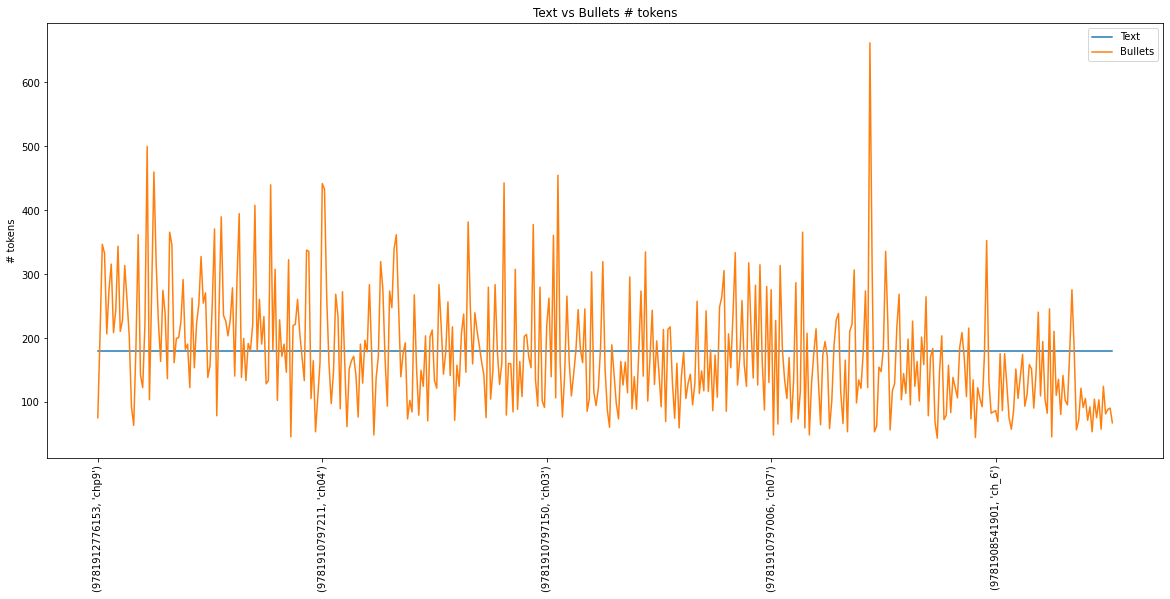

In [50]:
fig, ax = plt.subplots(figsize=(20, 8))

rects1 = ax.plot(
    [180]*len(df),
    label='Text')
rects2 = ax.plot(
    df_comp.bullets_num_tokens.tolist(),
    label='Bullets')

ax.set_title('Text vs Bullets # tokens')
ax.set_ylabel('# tokens')
xticks = list(zip(df_comp.index.get_level_values(0), df_comp.index.get_level_values(1)))
ax.set_xticklabels(xticks, rotation=90)
ax.legend()
plt.savefig(OUTPUT_PATH+'180_summary_vs_bullets.png')
plt.show()

In [51]:
print('Mean Absolute Error:\n')
np.sum(np.abs(180-df_comp.bullets_num_tokens)) / len(df_comp)

Mean Absolute Error:



70.1832229580574

On the other hand, deciding to produce reference summaries with a fixed length produce a much lower MAE of 70.